<a href="https://colab.research.google.com/github/Gr3gP/Misc-Projects/blob/main/PINNs_Overview_and_Builds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Solving an ODE with a neural network

https://towardsdatascience.com/how-to-solve-an-ode-with-a-neural-network-917d11918932

In [ ]:
#we will use JAX for this implementation
import jax.numpy as np

def sigmoid(x): 
    return 1./(1. + np.exp(-x))

def f(params, x): 
    w0 = params[:10]
    b0 = params[10:20]
    w1 = params[20:30]
    b1 = params[30]
    x = sigmoid(x*w0 + b0)
    x = sigmoid(np.sum(x*w1) + b1)
    return x

We are using JAX here so that later on we can calculate the derivatives of f through automatic differentiation.

f has two arguments; params that are an arrray of netowork parameters, and an input value(x). 

In [ ]:
#network aprams can be initialized randomly using a normal distribution
#PRNG is a pseudo-random number generator
from jax import random

key = random.PRNGKey(0)
params = random.normal(key, shape=(31,))

In [ ]:
#the derivative of f with respect to x can be obtained by th e following:
from jax import grad
dfdx = grad(f, 1)

The 1 in the above code tell sus we want the gradient of f with reposect to its second argument x(zero-based indexng). Jax's `grad` will return a function that evaluated the gradient of f and has teh same arguments as the original f. 

In [ ]:
#we want to solve our ODE in the domain -2<=x<=2. 
#just have to create an array of input values where 401 is an arbitrary 
#choice to have a resolution of .01 in our chosen interval

inputs = np.linspace(-2., 2., num=401)

f will however accept a single value x as input. we would pass an array but for differntiation purposes, JAX requires a saclar function. so we have to pass a single value as input in order to get a single value as output. To efficiently compute f and its derivate dfdx for an array of input values, we vectorize those functions using vmap:

In [ ]:
from jax import vmap

f_vect = vmap(f, (None, 0))
dfdx_vect = vmap(dfdx, (None, 0))

Where `(None,0)` specifies that each function is to be mapped over the `0` axis of the second argument (`x`), while the first argument (`params`) should be left untouched (with `None`, it will be broadcasted across the mapping)

In [ ]:
#we now define our loss function  
from jax import jit

@jit
def loss(params, input):
    eq = dfdx_vect(params, inputs) + 2.*inputs*f_vect(params, inputs)
    ic = f(params, 0.) - 1.
    return np.mean(eq*2) + ic**2

Note how the differential equation y’=-2xy and the initial condition y(0)=1 have been captured in eq and ic, respectively. They have been expressed as y’+2xy=0 and y(0)-1=0 in order to minimize the residuals y’+2xy and y(0)-1 during the training process. We use JIT (just-in-time compilation) on this function to speed up its execution on accelerator hardware, such as a GPU or a TPU, if available.

In [ ]:
grad_loss = jit(grad(loss, 0))

Where zero means we want the gradient of the loss function with repspect to its first argument(`params`). JIT speeds up the execution. 

TO begin training, we will use gradient descent with Nezterov momentum. Nesterov Accelerated Gradient(NAG) = 

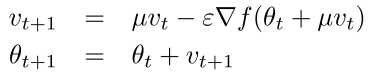

In [ ]:
#implement training:
epochs =1000
learning_rate = 0.1
momentum = 0.99
velocity = 0.

for epoch in range(epochs):
    if epoch % 100 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss(params, inputs)))
    gradient = grad_loss(params + momentum*velocity, inputs)
    velocity = momentum*velocity - learning_rate*gradient
    params += velocity

epoch:   0 loss: 0.434892
epoch: 100 loss: -2.502515
epoch: 200 loss: -2.503096
epoch: 300 loss: -2.504607
epoch: 400 loss: -2.512487
epoch: 500 loss: -2.536180
epoch: 600 loss: -2.578799
epoch: 700 loss: -1.439271
epoch: 800 loss: -1.009866
epoch: 900 loss: nan


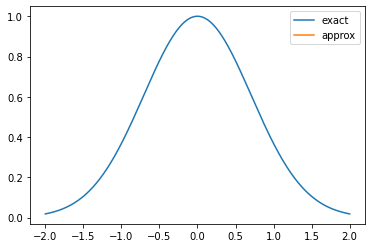

In [ ]:
#run model
import matplotlib.pyplot as plt

plt.plot(inputs, np.exp(-inputs**2), label='exact')
plt.plot(inputs, f_vect(params, inputs), label='approx')
plt.legend()
plt.show()

WE can see in the above plot the two lines are basically indistinguishable.

Now lets redefine our domain(inputs) and plot the model again and see how it changes.

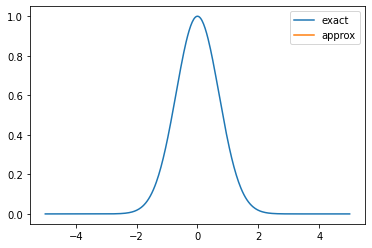

In [ ]:
#redefine inputs
inputs = np.linspace(-5., 5., num=401)

#replot results

plt.plot(inputs, np.exp(-inputs**2), label='exact')
plt.plot(inputs, f_vect(params, inputs), label='approx')
plt.legend()
plt.show()

#JAX implementation using Tanh activation functions

epoch:   0 loss: -4.233121
epoch: 100 loss: nan
epoch: 200 loss: nan
epoch: 300 loss: nan
epoch: 400 loss: nan
epoch: 500 loss: nan
epoch: 600 loss: nan
epoch: 700 loss: nan
epoch: 800 loss: nan
epoch: 900 loss: nan


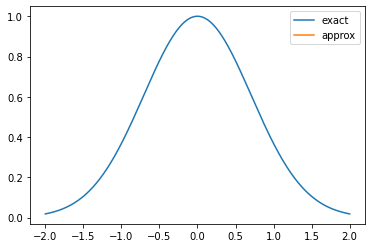

In [ ]:
import jax.numpy as np

def tanh(x):
   return (np.exp(x) - np.exp(-x)) /  (np.exp(x) + np.exp(-x))

def f(params, x):
    w0 = params[:10]
    b0 = params[10:20]
    w1 = params[20:30]
    b1 = params[30]
    x = tanh(x*w0 + b0)
    x = tanh(np.sum(x*w1) + b1)
    return x

#network params can be initialized randomly using a normal distribution
#PRNG is a pseudo-random number generator
from jax import random

key = random.PRNGKey(0)
params = random.normal(key, shape=(31,))

#the derivative of f with respect to x can be obtained by th e following:
from jax import grad
dfdx = grad(f, 1)

#we want to solve our ODE in the domain -2<=x<=2. 
#just have to create an array of input values where 401 is an arbitrary 
#choice to have a resolution of .01 in our chosen interval

inputs = np.linspace(-2., 2., num=401)


from jax import vmap

f_vect = vmap(f, (None, 0))
dfdx_vect = vmap(dfdx, (None, 0))


#we now define our loss function  
from jax import jit

@jit
def loss(params, input):
    eq = dfdx_vect(params, inputs) + 2.*inputs*f_vect(params, inputs)
    ic = f(params, 0.) - 1.
    return np.mean(eq*2) + ic**2


grad_loss = jit(grad(loss, 0))


#implement training:
epochs =1000
learning_rate = 0.1
momentum = 0.99
velocity = 0.

for epoch in range(epochs):
    if epoch % 100 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss(params, inputs)))
    gradient = grad_loss(params + momentum*velocity, inputs)
    velocity = momentum*velocity - learning_rate*gradient
    params += velocity


#run model
import matplotlib.pyplot as plt

plt.plot(inputs, np.exp(-inputs**2), label='exact')
plt.plot(inputs, f_vect(params, inputs), label='approx')
plt.legend()
plt.show()

# Another PINN implementation using Tensorflow

https://towardsdatascience.com/using-neural-networks-to-solve-ordinary-differential-equations-a7806de99cdd

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# initial condition
f0 = 1
# infinitesimal small number
inf_s = np.sqrt(np.finfo(np.float32).eps)

# Parameters
learning_rate = 0.01
training_steps = 1000
batch_size = 1000
display_step = training_steps/100

# Network Parameters
n_input = 1    # input layer number of neurons
n_hidden_1 = 512 # 1st layer number of neurons
n_hidden_2 = 512 # 2nd layer number of neurons
n_output = 1    # output layer number of neurons

weights = {
    'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_hidden_2, n_output]))
}
biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_output]))
}

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

In [ ]:
#create model 
def multilayer_perceptron(x):
    x = np.array([[[x]]], dtype='float32')
    #hidden fully connected layer wiht 32 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    #hidden fully connected layer with 32 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.sigmoid(layer_2)
    #output fully connected layer
    output = tf.matmul(layer_2, weights['out'] + biases['out'])
    return tf.nn.sigmoid(output)

#universal Approximator
def g(x):
    return x * multilayer_perceptron(x) + f0

#given EDO
def f(x):
    return 2*x

#custom loss function to appoximate the derivatives
def custom_loss():
  summation = []
  for x in np.linspace(0,1,10):
      dNN = (g(x+inf_s)-g(x))/inf_s
      summation.append((dNN - f(x))**2)
  return tf.reduce_sum(tf.abs(summation))
  #return tf.sqrt(tf.reduce_mean(tf.abs(summation)))

In [ ]:
def train_step():
    with tf.GradientTape() as tape:
        loss = custom_loss()
    trainable_variables = list(weights.values()) + list(biases.values())
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))        

In [ ]:
for i in range(training_steps):
    train_step()
    if i % display_step == 0:
        print("loss: %f " % (custom_loss()))

loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.073537 
loss: 4.

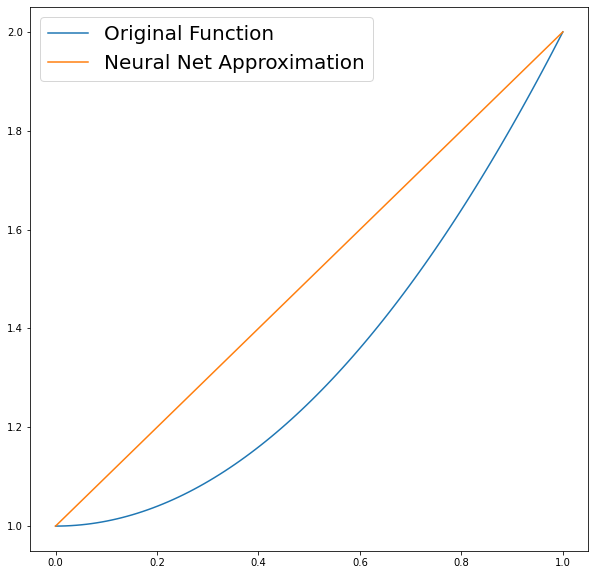

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(10,10))
#True solution '
def true_solution(x): 
    return x**2 + 1

X = np.linspace(0, 1, 100)
result = []
for i in X:
    #results.append(f(i)
    result.append(g(i).numpy()[0][0][0])

S = true_solution(X)

plt.plot(X, S, label="Original Function")
plt.plot(X, result, label="Neural Net Approximation")
plt.legend(loc=2, prop={'size': 20})
plt.show()

#PINN with tanh activation functions

In [ ]:
#We are going to rerun and train the model using tanh activation functions. Sigmoids may not be the best choice since the 
#second and higher order deirvaties of these functinos will be zero.

#create model 
def multilayer_perceptron(x):
    x = np.array([[[x]]], dtype='float32')
    #hidden fully connected layer wiht 32 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.tanh(layer_1)
    #hidden fully connected layer with 32 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.tanh(layer_2)
    #output fully connected layer
    output = tf.matmul(layer_2, weights['out'] + biases['out'])
    return tf.nn.tanh(output)

#universal Approximator
def g(x):
    return x * multilayer_perceptron(x) + f0

#given EDO
def f(x):
    return 2*x

#custom loss function to appoximate the derivatives
def custom_loss():
  summation = []
  for x in np.linspace(0,1,10):
      dNN = (g(x+inf_s)-g(x))/inf_s
      summation.append((dNN - f(x))**2)
  return tf.reduce_sum(tf.abs(summation))
  #return tf.sqrt(tf.reduce_mean(tf.abs(summation)))

In [ ]:
def train_step():
    with tf.GradientTape() as tape:
        loss = custom_loss()
    trainable_variables = list(weights.values()) + list(biases.values())
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))        

In [ ]:
for i in range(training_steps):
    train_step()
    if i % display_step == 0:
        print("loss: %f " % (custom_loss()))

for i in range(training_steps):
    train_step()
    if i % display_step == 0:
        print("loss: %f" % (custom_loss()))

loss: 43.942223 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4.074151 
loss: 4

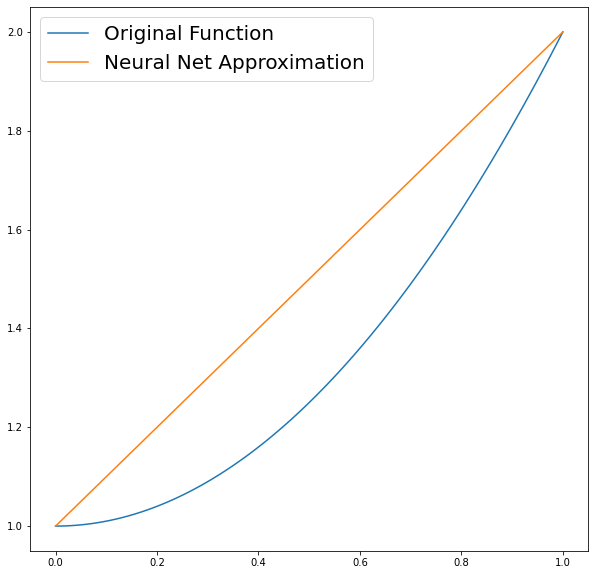

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(10,10))
#True solution '
def true_solution(x): 
    return x**2 + 1

X = np.linspace(0, 1, 100)
result = []
for i in X:
    #results.append(f(i)
    result.append(g(i).numpy()[0][0][0])

S = true_solution(X)

plt.plot(X, S, label="Original Function")
plt.plot(X, result, label="Neural Net Approximation")
plt.legend(loc=2, prop={'size': 20})
plt.show()